In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version", tf.__version__)

Tensorflow version 2.10.0


<Figure size 640x480 with 0 Axes>

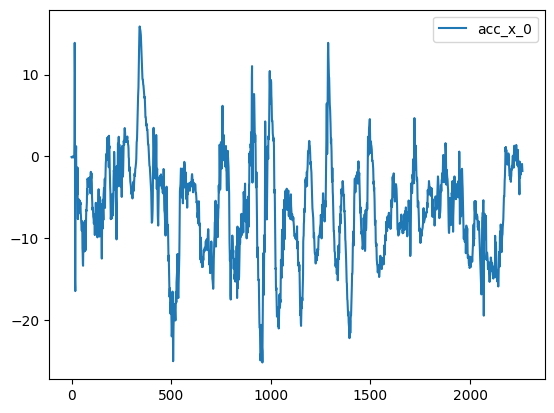

In [4]:
holding = pd.read_csv('../data/holding-processed.csv').astype(np.float32)
moving = pd.read_csv('../data/moving-processed.csv').astype(np.float32)
shaking = pd.read_csv('../data/shaking-processed.csv').astype(np.float32)

plt.figure()
moving.plot(y=['acc_x_0'])
plt.legend(loc='best')
plt.show()

In [36]:
dataset = pd.concat([holding, moving, shaking])
print(dataset)

      acc_x_0  acc_x_1  acc_x_2  acc_x_3  acc_x_4  acc_x_5   acc_x_6  \
0    -0.03125 -0.06250 -0.06250  0.00000  0.06250  0.06250   0.00000   
1    -0.06250 -0.06250  0.00000  0.06250  0.06250  0.00000   0.00000   
2    -0.06250  0.00000  0.06250  0.06250  0.00000  0.00000  -0.09375   
3     0.00000  0.06250  0.06250  0.00000  0.00000 -0.09375  -0.12500   
4     0.06250  0.06250  0.00000  0.00000 -0.09375 -0.12500  -0.15625   
...       ...      ...      ...      ...      ...      ...       ...   
1697 -2.28125  1.18750  0.81250  0.68750  2.34375  4.84375   4.75000   
1698  1.18750  0.81250  0.68750  2.34375  4.84375  4.75000   1.50000   
1699  0.81250  0.68750  2.34375  4.84375  4.75000  1.50000  -3.93750   
1700  0.68750  2.34375  4.84375  4.75000  1.50000 -3.93750  -7.03125   
1701  2.34375  4.84375  4.75000  1.50000 -3.93750 -7.03125 -10.84375   

       acc_x_7   acc_x_8   acc_x_9  ...  acc_z_39  acc_z_40  acc_z_41  \
0      0.00000  -0.09375  -0.12500  ...  37.00000  32.15625  2

In [43]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

#train_dataset = dataset.sample(frac=0.8, random_state=0)
#test_dataset = dataset.drop(train_dataset.index)

# copy dataset
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# pick out labels
train_labels = train_features[['val']].copy()
test_labels = test_features[['val']].copy()

# drop labels from features
train_features = train_features.drop(['val'], axis=1)
test_features = test_features.drop(['val'], axis=1)

print(len(test_dataset), len(train_dataset))

1148 4590


In [44]:
np.set_printoptions(precision=3, suppress=True)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

In [45]:
# build model

def build_and_compile_model(norm):
  model = keras.Sequential([
      layers.InputLayer(input_shape=((144,)), dtype=np.float32),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_mouse_model = build_and_compile_model(normalizer)
print(dnn_mouse_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               18560     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
history = dnn_mouse_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

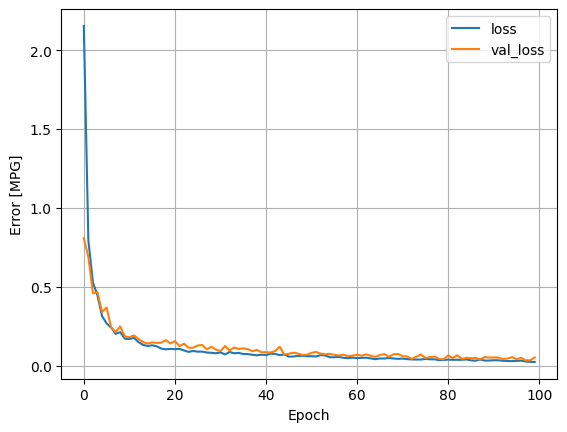

In [47]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

5/5 [==============================] - 0s 664us/step


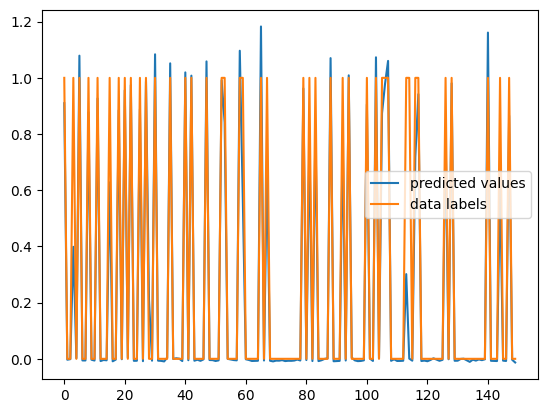

In [54]:
FROM = 100
TO = 250


x = np.arange(0, TO - FROM)

plt.plot(x, dnn_mouse_model.predict(test_features.iloc[FROM:TO]).T[0], label="predicted values")
plt.plot(x, test_labels['val'].iloc[FROM:TO], label="data labels")
#plt.plot(x, 0.1 * test_features['acc_y_43'].iloc[FROM:TO], label="acc_y")
plt.legend(loc='best')
plt.show()

# Convert the model

In [86]:
# Save as SavedModel

print(dnn_mouse_model)
print(type(dnn_mouse_model))

tf.saved_model.save(
    dnn_mouse_model, 'SavedModel/', signatures=None, options=None
)

<class 'keras.engine.sequential.Sequential'>
INFO:tensorflow:Assets written to: SavedModel/assets


INFO:tensorflow:Assets written to: SavedModel/assets


In [134]:
# Convert the SavedModel

#quantization

""" def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_features).batch(1).take(400):
        yield [tf.dtypes.cast(input_value, np.float32)] """

def representative_data_gen():
    num_samples = 200
    samples = []
    for i in range(num_samples):
        idx = np.random.randint(len(test_features))
        samples.append(np.array(test_features.iloc[idx:idx+1]))

    samples = np.array(samples)
    img = tf.data.Dataset.from_tensor_slices(samples).batch(1)

    for i in img.take(num_samples):
        yield [i]

def representative_dataset():
    for i in range(200):
        idx = np.random.randint(0, len(test_features))
        yield (np.array(test_features.iloc[idx:idx+1, :]))

#converter = tf.lite.TFLiteConverter.from_saved_model('SavedModel/')
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_mouse_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmpt6ow_cwd/assets


INFO:tensorflow:Assets written to: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmpt6ow_cwd/assets
/Users/ursincantieni/Library/Python/3.9/lib/python/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-12 17:06:32.211637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-12 17:06:32.211651: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-12 17:06:32.211728: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gj/6njgb8g5483122ych_08wylh0000gn/T/tmpt6ow_cwd
2022-12-12 17:06:32.213044: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-12 17:06:32.213054: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug in

# Test TfLite model

In [119]:
columns = ["col" + str(i) for i in range(144)]
d = {
    columns[i] : [6]
    for i in range(144)
}
df = pd.DataFrame(data=d)

print(dnn_mouse_model.predict(df)) 

1/1 [==============================] - 0s 12ms/step
[[0.238]]


5/5 [==============================] - 0s 819us/step


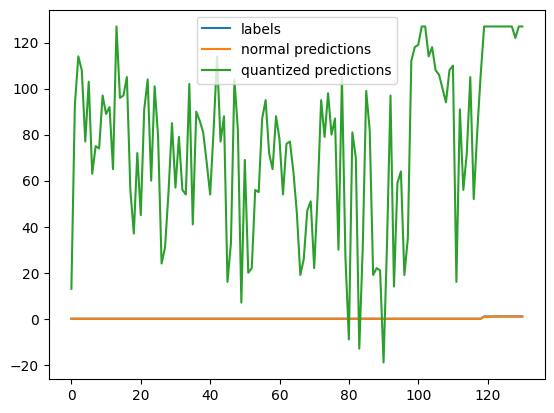

In [135]:
PREDICT_QUANTIZED = True

predictions_normal = dnn_mouse_model.predict(test_features)
labels = test_labels

if PREDICT_QUANTIZED:
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]
    input = interpreter.get_input_details()[0]

    predictions_quantized = []

    for i in range(len(test_features)):
        input_data = tf.constant(test_features[i:i+1], dtype=np.int8) #dtype=np.int8
        interpreter.set_tensor(input['index'], input_data)
        interpreter.invoke()
        predictions_quantized.append(interpreter.get_tensor(output['index'])[0])
    
    predictions_quantized = np.array(predictions_quantized)

x = [i for i in range(len(test_features))]
plt.plot(x, labels, label='labels')
plt.plot(x, predictions_normal, label='normal predictions')
if PREDICT_QUANTIZED:
    plt.plot(x, predictions_quantized, label='quantized predictions')
plt.legend()